In [1]:
import argparse
import yaml
import glob
import os
import random
import re
from importlib import import_module
from pathlib import Path

import numpy as np
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import glob

import wandb
from dataset import CustomDataLoader
from losses import create_criterion
from optim_sche import get_opt_sche
from metrics import get_metrics_from_matrix, top_k_labels, get_confusion_matrix
from visualize import draw_batch_images
import shutil


category_names = [
    'Aerosol',
    'Alcohol',
    'Awl',
    'Axe',
    'Bat',
    'Battery',
    'Bullet',
    'Firecracker',
    'Gun',
    'GunParts',
    'Hammer',
    'HandCuffs',
    'HDD',
    'Knife',
    'Laptop',
    'Lighter',
    'Liquid',
    'Match',
    'MetalPipe',
    'NailClippers',
    'PortableGas',
    'Saw',
    'Scissors',
    'Screwdriver',
    'SmartPhone',
    'SolidFuel',
    'Spanner',
    'SSD',
    'SupplymentaryBattery',
    'TabletPC',
    'Thinner',
    'USB',
    'ZippoOil',
    'Plier',
    'Chisel',
    'Electronic cigarettes',
    'Electronic cigarettes(Liquid)',
    'Throwing Knife'
]


def seed_everything(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]


def increment_path(path, exist_ok=False):
    """Automatically increment path, i.e. runs/exp --> runs/exp0, runs/exp1 etc.

    Args:
        path (str or pathlib.Path): f"{model_dir}/{args.name}".
        exist_ok (bool): whether increment path (increment if False).
    """
    path = Path(path)
    if (path.exists() and exist_ok) or (not path.exists()):
        return str(path)
    else:
        dirs = glob.glob(f"{path}*")
        matches = [re.search(rf"%s(\d+)" % path.stem, d) for d in dirs]
        i = [int(m.groups()[0]) for m in matches if m]
        n = max(i) + 1 if i else 2
        return f"{path}{n}"


def createDirectory(save_dir):
    try:
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
    except OSError:
        print("Error: Failed to create the directory.")

In [2]:
from torch import nn
from torchvision import models

class multihead_with_quant(nn.Module):
    def __init__(self, num_classes, cls_classes, device):
        super().__init__()
        self.backbone = models.resnet101(pretrained=True)
        self.backbone.fc = nn.Identity()
        self.fcs = nn.ModuleList([nn.Linear(2048, 2) for _ in range(num_classes)])
        self.device = device
        self.quant = torch.quantization.QuantStub()
        self.dequant = torch.quantization.DeQuantStub()

        self.gradients = None
        self.tensorhook = []
        self.layerhook = []
        self.selected_out = None
        
        self.layerhook.append(self.backbone.layer4.register_forward_hook(self.forward_hook()))
        
        # for p in self.backbone.parameters():
        #     p.requires_grad = True
    
    def activations_hook(self,grad):
        self.gradients = grad

    def get_act_grads(self):
        return self.gradients

    def forward_hook(self):
        def hook(module, inp, out):
            self.selected_out = out
            self.tensorhook.append(out.register_hook(self.activations_hook))
        return hook

    def forward(self, inputs):
        inputs = self.quant(inputs)
        feat = self.backbone(inputs)
        vecs = []
        for fc in self.fcs:
            vec = fc(feat)
            vecs.append(vec)
        
        stack = torch.stack(vecs, axis = 0)
        stack = stack.permute(1,0,2)
        
        return self.dequant(stack), 0, self.selected_out


    def get_loss(self, outs, cls_outs, labels, criterion):
        label_binary = self.get_binary_label(labels).to(torch.float32)
        losses = []
        for out, label in zip(outs, label_binary):
            _loss = criterion(out, label)
            losses.append(_loss)
        
        return torch.sum(torch.stack(losses))

    def get_binary_label(self, labels):
        _ones = torch.ones((labels.shape))
        counterpart = _ones - labels
        cats = torch.stack([counterpart, labels], axis = 0)
        return cats.permute(1,2,0).to(self.device)

In [3]:
seed_everything(1004)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
identity = False

# dataset
import sys
sys.path.append('/opt/ml/finalproject/multilabel/baseline')
from dataset import train_transform, val_transform

val_dataset = CustomDataLoader(
    image_dir="/opt/ml/finalproject/data/",
    data_dir="/opt/ml/finalproject/data/eval/eval.json",
    mode="eval",
    transform=val_transform
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=1,
    num_workers=1,
    shuffle=False,
    pin_memory=use_cuda,
    drop_last=True,
)

model_weight_dir = '/opt/ml/runs/mseloss_clsupgrade_multihead_with_quant/best.pth'
model = multihead_with_quant(38, 6, 'cuda')
model = model.to('cuda')
state_dict = torch.load(model_weight_dir)
model.load_state_dict(state_dict)
model.train()
print('loaded')

# loss & optimizer
criterion = create_criterion("mse")

loading annotations into memory...
Done (t=0.68s)
creating index...
index created!
loaded


In [4]:
images, labels = next(iter(val_loader))
images = images.to(device)
outs, cls_outs, act = model(images)

loss = model.get_loss(
    outs,
    cls_outs,
    labels,
    criterion
)

loss.backward()

In [5]:
act = act.detach().cpu()
grads = model.get_act_grads().detach().cpu()
pooled_grads = torch.mean(grads, dim=[0,2,3]).detach().cpu()

In [6]:
act.shape, pooled_grads.shape

(torch.Size([1, 2048, 16, 16]), torch.Size([2048]))

In [7]:
for i in range(act.shape[1]):
    act[:,i,:,:] += pooled_grads[i]

In [16]:
heatmap_j = torch.mean(act, dim = 1).squeeze()
heatmap_j_max = heatmap_j.max(axis = 0)[0]
heatmap_j /= heatmap_j_max

In [27]:
from skimage.transform import resize
import matplotlib as mpl
heatmap_j = resize(heatmap_j,(512,512),preserve_range=True)
cmap = mpl.cm.get_cmap('jet',256)
heatmap_j2 = cmap(heatmap_j,alpha = 0.5)
heatmap_j3 = (heatmap_j > 0.75)

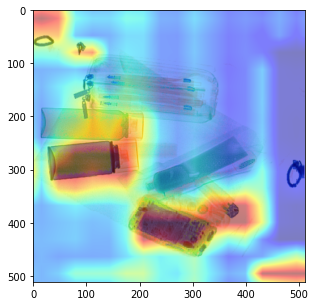

In [28]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,1,figsize = (5,5))
im = (images*0.2+0.5)[0].permute(1,2,0).cpu()
axs.imshow(im)
axs.imshow(heatmap_j2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


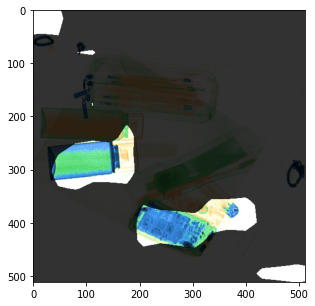

In [20]:
j4 = heatmap_j3 + 0.2

import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,1,figsize = (5,5))
im = (images*0.2+0.5)[0].permute(1,2,0).cpu()

for _ in range(3):
    im[:, :, _] *= j4

axs.imshow(im)

In [25]:
[category_names[x] for x in np.where(labels == 1)[1]]